In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from transformers import ViTFeatureExtractor, ViTModel, ViTConfig, AutoConfig

from PIL import Image
from torchsummary import summary
import GPUtil
%matplotlib inline

In [2]:
cd G:\project\fifth_try\data

G:\project\fifth_try\data


# import training data

In [23]:
import numpy as np
image = np.load("W_Image_data_per_episode.npy",mmap_mode='c')
episode_length = np.load("W_Episode.npy",mmap_mode='c')
velocity = np.load("W_Velocity.npy",mmap_mode='c')
r_theta_data = np.load("W_R_T_data.npy",mmap_mode='c')


test_image = np.load("W_test_Image_data_per_episode.npy",mmap_mode='c')
test_episode_length = np.load("W_test_Episode.npy",mmap_mode='c')
test_velocity = np.load("W_test_Velocity.npy",mmap_mode='c')
test_r_theta_data = np.load("W_test_R_T_data.npy",mmap_mode='c')

In [4]:
image = image.astype(np.int32)
test_image = test_image.astype(np.int32)

In [5]:
image = np.reshape(image,[22218,120,160,3])
test_image = np.reshape(test_image,[2266,120,160,3])

In [6]:
image_array = image[15855]

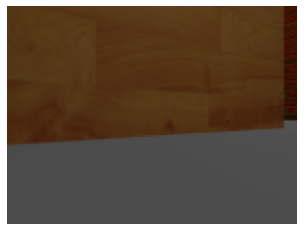

In [7]:
import matplotlib.pyplot as plt
plt.imshow(image_array)
plt.axis('off')  # Optional: turn off axis ticks and labels
plt.show()

# Rounding Velocity

In [8]:
velocity = np.around(velocity,decimals=1)
#r_theta_data = np.around(r_theta_data,decimals=2)


test_velocity = np.around(test_velocity,decimals=1)
#test_r_theta_data = np.around(test_r_theta_data,decimals=2)

# GPU setup

In [9]:
# Define function to add data/model in to GPU (cuda)
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    # if data is list or tuple, move each of them to device
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device) -> None:
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            # yield only execuate when the function is called
            yield to_device(b, self. device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()

# prepare Input data

In [10]:
input_shape = (120, 160, 3)
num_epochs = 100

x_train = image
y_train = velocity

x_test = test_image
y_test = test_velocity
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_train shape: {x_test.shape} - y_train shape: {y_test.shape}")

x_train shape: (22218, 120, 160, 3) - y_train shape: (22218, 2, 3)
x_train shape: (2266, 120, 160, 3) - y_train shape: (2266, 2, 3)


In [11]:
# Define your MLP architecture (you can experiment with different architectures)
class RelativeDistanceMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RelativeDistanceMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)  # Input size: input_dim, Output size: 128
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)  # Output size adjusted to match the ViT feature extractor's output

    def forward(self, relative_distance):
        x = torch.relu(self.fc1(relative_distance))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

In [41]:
# Define training dataset
class robotDataset(Dataset):
    def __init__(self, image, relative_distance, velocity, trans_transform=None,use_classifier_token = False):
        self.vel = velocity
        self.images = image
        self.rel_dist = relative_distance
        self.trans_transform = trans_transform
        self.use_classifier_token = use_classifier_token
        # Instantiate the MLP for encoding relative distance
        output_dim = 1024
        self.mlp = RelativeDistanceMLP(input_dim=2, output_dim=output_dim)


    def __len__(self):
        return len(self.vel)
    def __getitem__(self, idx):
        # Get image
        image = self.images[idx]
        # Preprocess image and extract patches using the ViT feature extractor
        image_trans = self.trans_transform(image, return_tensors='pt')
        #print(f'@@@@ {image_trans.shape}')
        image_trans = image_trans['pixel_values'].squeeze()

        # Get the corresponding relative distance
        relative_distance = self.rel_dist[idx]

        # Pass the relative distance through the MLP to obtain the encoded relative distance features
        encoded_relative_distance = self.mlp(relative_distance)


        if self.use_classifier_token:
            # Extract the classifier token from the ViT model's output
            outputs = self.trans_transform(image)
            classifier_token = outputs.last_hidden_state[:, 0, :]  # Assuming the classifier token is at position 0
            # Concatenate the image patches, the encoded relative distance, and the classifier token
            concatenated_features = torch.cat([image_trans, encoded_relative_distance, classifier_token], dim=0)
        else:
            # Concatenate the image patches and the encoded relative distance features
            print(f'image ==> {image_trans.shape}')
            print(f'encoded relative_distance ==> {encoded_relative_distance.shape}')
            concatenated_features = torch.cat([image_trans, encoded_relative_distance], dim=0)
        print(f"Concatenated shape: {concatenated_features.shape}")
        velocity = self.vel[idx]
        return concatenated_features, velocity
trans_transform = ViTFeatureExtractor.from_pretrained('google/vit-large-patch16-224')

res_transform = transforms.Compose([
    transforms.Resize(224),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = torch.tensor(image,device=device,dtype=torch.float32)
r_theta_data = torch.tensor(r_theta_data,device=device,dtype=torch.float32)
velocity = torch.tensor(velocity,device=device,dtype=torch.float32)

train_ds = robotDataset(image,r_theta_data,velocity, trans_transform=trans_transform)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)


C:\Users\imali\AppData\Local\Temp\ipykernel_11296\3243789493.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image,device=device,dtype=torch.float32)
C:\Users\imali\AppData\Local\Temp\ipykernel_11296\3243789493.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_theta_data = torch.tensor(r_theta_data,device=device,dtype=torch.float32)
C:\Users\imali\AppData\Local\Temp\ipykernel_11296\3243789493.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  velocity = torch.tensor(velocity,device=device,dtype=torch.float

# Modify ViT

In [27]:
# Modify the model - ViT model
model_trans = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
'''
loads the complete pretrained ViTModel from HuggingFace Transformers. This includes all the model layers -
the patch embedding, transformer encoder, layer normalization, classification head, etc.
'''
count = 0
for child in model_trans.children():
    count += 1
    if count < 4:
        #The first four layers are not trainable ==>  lower-level feature extraction
        for param in child.parameters():
            param.requires_grad = False

layers_trans = list(model_trans.children()) # Get all the layers from the Transformer model
model_trans_top = nn.Sequential(*layers_trans[:-2]) # Remove the normalization layer and pooler layer
trans_layer_norm = list(model_trans.children())[2] # Get the normalization layer

# The Model

In [28]:
class model_final(nn.Module):
    def __init__(self, model_trans_top, trans_layer_norm,dp_rate=0.3):
        super().__init__()
        # All the trans model layers
        self.model_trans_top = model_trans_top
        self.trans_layer_norm = trans_layer_norm
        self.trans_flatten = nn.Flatten()
        self.trans_linear = nn.Linear(150528, 2048)
        self.dropout = nn.Dropout(dp_rate)

    def forward(self, trans_b, res_b):
        # Get intermediate outputs using hidden layer
        result_trans = self.model_trans_top(trans_b)
        patch_state = result_trans.last_hidden_state[:,1:,:] # Remove the classification token and get the last hidden state of all patchs
        result_trans = self.trans_layer_norm(patch_state)
        result_trans = self.trans_flatten(result_trans) #instead of "result_trans" it was patch_state
        result_trans = self.dropout(result_trans)
        result_trans = self.trans_linear(result_trans)

        return result_trans

model = model_final(model_trans_top, trans_layer_norm)
# model.load_state_dict(torch.load('model_weights_1228'))

# Add data and model to GPU

In [29]:

train_dl = DeviceDataLoader(train_dl, device)
model = to_device(model, device)


# Define Optimizer and LearningRate scheduler

In [30]:
params = [param for param in list(model.parameters()) if param.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-7, momentum=0.2)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True)

# Fit function AND doing grad steps

In [31]:
def fit(epochs, model, train_dl):
    opt = optimizer
    sched = lr_scheduler
    loss_func = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        batch_num = 1
        for x_trans, yb in train_dl:
            # Pass the opt so that funciton will get trained
            total_loss = 0
            preds = model(x_trans)
            loss = loss_func(preds.squeeze(), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            print('\r', f'batch #{batch_num}: {loss}', end='')
            batch_num += 1
            total_loss += loss.item()
        sched.step(total_loss)
        print('\n', f'Epoch: ({epoch+1}/{epochs}) Loss = {total_loss}')

In [42]:
# Training the model and save weights
fit(num_epochs, model, train_dl)
torch.save(model.state_dict(), "model_weights")

image ==> torch.Size([3, 224, 224])
encoded relative_distance ==> torch.Size([1024])


RuntimeError: Tensors must have same number of dimensions: got 3 and 1